# Segmenting and Clustering Neighborhoods in Toronto

#### auth. Daniel de Amaral

#### This notebook contains the activities of the final project of week 3 of Applied final capstone

#### ...and has the following structure:

1. First activity: Web-Scrapping (Section 1)

2. Second activity: Geolocation data (Section 2)

3. Third activity: Explore and Cluster (Section 3+)

## 1. Web-Scrapping with BeautifulSoup

#### request the page table

In [1]:
import requests

page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
page

<Response [200]>

#### scrapping the table

In [2]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

In [3]:
data = []

# find table in html page
table = soup.find('table', attrs={'class':'wikitable sortable'})
table_body = table.find('tbody')

# populating data array
rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) # Get rid of empty values

#### covert into pandas dataframe

In [4]:
import pandas as pd

data.pop(0) # remove blank row
data = pd.DataFrame(data, columns = ['PostalCode', 'Borough', 'Neighborhood']) # create col names

data.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
# "Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned."
data = data.query("Borough != 'Not assigned'").reset_index(drop=True)

In [6]:
data.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [7]:
data.shape

(103, 3)

## 2. Get Coordinates (lat, lon)

In [8]:
coord = pd.read_csv('http://cocl.us/Geospatial_data')
coord.columns = ['PostalCode', 'Latitude', 'Longitude']
coord.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
# inner join data
data = pd.merge(data, coord, on = 'PostalCode')

In [10]:
data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## 3. Explore and cluster the neighborhoods

#### Use geopy library to get the latitude and longitude values of New York City.

In [11]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Toronto. So let's slice the original dataframe and create a new dataframe of the Toronto data.

In [16]:
toronto_data = data[data['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ca_explorer</em>, as shown below.

In [20]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent = "ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Canada City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Canada City are 43.6534817, -79.3839347.


In [21]:
# create map of toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], 
                                           toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [22]:
CLIENT_ID = 'KP0ETH3YS10QGR2GEQOOY14131IIUBM1DR0QMLAYTOMDPOGI' # your Foursquare ID
CLIENT_SECRET = 'KSNIWWSDIZEFTTXPI00XIEQX5GWOLN23VCRV5JGWHX3NJFJN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KP0ETH3YS10QGR2GEQOOY14131IIUBM1DR0QMLAYTOMDPOGI
CLIENT_SECRET:KSNIWWSDIZEFTTXPI00XIEQX5GWOLN23VCRV5JGWHX3NJFJN


## 4. Explore Neighborhoods in Toronto

#### Let's create a function to explore all the neighborhoods in Toronto

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
# applying funcion in each neighborhood
toronto_venues = getNearbyVenues(names = toronto_data['Neighborhood'],
                                   latitudes = toronto_data['Latitude'],
                                   longitudes = toronto_data['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


#### Let's check the size of the resulting dataframe

In [29]:
print(toronto_venues.shape)
toronto_venues.head()

(1615, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


Let's check how many venues were returned for each neighborhood

In [32]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,59,59,59,59,59,59
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,74,74,74,74,74,74
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,32,32,32,32,32,32


#### Let's find out how many unique categories can be curated from all the returned venues

In [35]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 231 uniques categories.


## 5. Analyze Each Neighborhood


In [36]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [38]:
toronto_onehot.shape

(1615, 231)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [39]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.014706,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.014706,0.000000,0.000000,0.014706,0.000000,0.000000
5,Christie,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.027027,0.013514,0.0000,0.0000,0.000,0.0000,0.000,0.013514,0.000000,...,0.013514,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.013514,0.000000
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.040000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000
8,Davisville,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.03125,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Let's confirm the new size

In [40]:
toronto_grouped.shape

(39, 231)

#### Let's print each neighborhood along with the top 5 most common venues

In [41]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
          venue  freq
0   Coffee Shop  0.08
1  Cocktail Bar  0.05
2          Café  0.03
3      Beer Bar  0.03
4    Restaurant  0.03


----Brockton, Parkdale Village, Exhibition Place----
                   venue  freq
0                   Café  0.13
1  Performing Arts Venue  0.09
2            Coffee Shop  0.09
3         Breakfast Spot  0.09
4                    Gym  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                venue  freq
0  Light Rail Station  0.12
1         Pizza Place  0.06
2       Auto Workshop  0.06
3          Comic Shop  0.06
4          Restaurant  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0     Airport Service  0.19
1      Airport Lounge  0.12
2    Airport Terminal  0.12
3             Airport  0.06
4  Airport Food Court  0.06


----Central Bay Street----
                 venue  freq
0

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [44]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Café,Seafood Restaurant,Bakery,Restaurant,Cheese Shop,Shopping Mall,Bistro
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Performing Arts Venue,Intersection,Italian Restaurant,Convenience Store,Nightclub,Bakery,Pet Store
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Pizza Place,Skate Park,Brewery,Burrito Place,Spa,Farmers Market,Fast Food Restaurant,Restaurant,Auto Workshop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Plane,Sculpture Garden
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Japanese Restaurant,Café,Thai Restaurant,Bar,Burger Joint,Bubble Tea Shop,Salad Place


In [67]:
neighborhoods_venues_sorted.shape

(39, 11)

## 6. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [64]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# find ideal number of clusters by elbow method
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# function returns WSS score for k values from 1 to kmax
wss = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    kmeanModel.fit(toronto_grouped_clustering)
    wss.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0])

In [65]:
K

range(1, 10)

Text(0, 0.5, 'Silhouette Score')

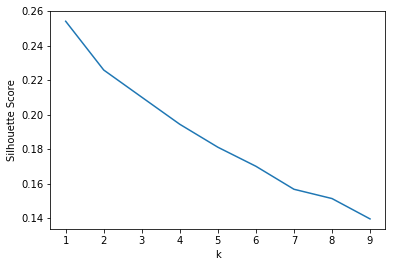

In [66]:
import matplotlib.pyplot as plt

plt.plot(K, wss)
plt.xlabel('k')
plt.ylabel('Silhouette Score')

In [70]:
# run k-means clustering
kmeans = KMeans(n_clusters = 2, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [71]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Pub,Bakery,Theater,Café,Breakfast Spot,Beer Store,Restaurant,Chocolate Shop
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Diner,Sushi Restaurant,Yoga Studio,Fried Chicken Joint,Burrito Place,Restaurant,Distribution Center,Italian Restaurant,Discount Store
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Cosmetics Shop,Café,Bubble Tea Shop,Japanese Restaurant,Middle Eastern Restaurant,Tea Room,Bakery,Movie Theater
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Café,Coffee Shop,Cocktail Bar,Gastropub,Restaurant,American Restaurant,Gym,Japanese Restaurant,Department Store,Italian Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Pub,Women's Store,Dance Studio,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


Finally, let's visualize the resulting clusters

In [74]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], 
                                  toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 7. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [78]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Park,Pub,Bakery,Theater,Café,Breakfast Spot,Beer Store,Restaurant,Chocolate Shop
1,Downtown Toronto,0,Coffee Shop,Diner,Sushi Restaurant,Yoga Studio,Fried Chicken Joint,Burrito Place,Restaurant,Distribution Center,Italian Restaurant,Discount Store
2,Downtown Toronto,0,Clothing Store,Coffee Shop,Cosmetics Shop,Café,Bubble Tea Shop,Japanese Restaurant,Middle Eastern Restaurant,Tea Room,Bakery,Movie Theater
3,Downtown Toronto,0,Café,Coffee Shop,Cocktail Bar,Gastropub,Restaurant,American Restaurant,Gym,Japanese Restaurant,Department Store,Italian Restaurant
4,East Toronto,0,Health Food Store,Trail,Pub,Women's Store,Dance Studio,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
5,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Beer Bar,Café,Seafood Restaurant,Bakery,Restaurant,Cheese Shop,Shopping Mall,Bistro
6,Downtown Toronto,0,Coffee Shop,Italian Restaurant,Sandwich Place,Japanese Restaurant,Café,Thai Restaurant,Bar,Burger Joint,Bubble Tea Shop,Salad Place
7,Downtown Toronto,0,Grocery Store,Café,Park,Restaurant,Candy Store,Italian Restaurant,Diner,Baby Store,Nightclub,Coffee Shop
8,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Gym,Deli / Bodega,Hotel,Thai Restaurant,Bookstore,Sushi Restaurant,Cosmetics Shop
9,West Toronto,0,Pharmacy,Bakery,Grocery Store,Supermarket,Gym,Furniture / Home Store,Middle Eastern Restaurant,Music Venue,Pet Store,Café


#### Cluster 2


In [80]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,1,Park,Event Space,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner
33,Downtown Toronto,1,Park,Playground,Trail,Cupcake Shop,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
